# Flow Cytometry

Notebook graphing out flow cytometry data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import scipy

from scipy import stats
from statsmodels.stats import multitest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

## Infection and interferon

In single cell data, transcription correlates with interferon probability. Does this appear in flow data?

MOI 0.1, 13h infection.

Load data, show thresholds.

These were stained for HA. 

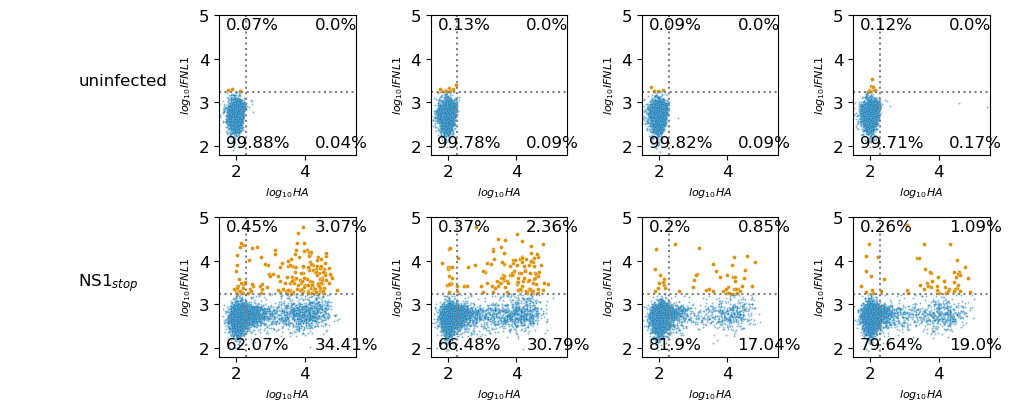

In [2]:
datafolder = "Data/FlowCytometry/HA/"
flow = []
for file in glob.glob(datafolder + '*.csv'):
    tempData = pd.read_csv(file)
    fileSeg = file.split('/')[-1].split('_')
    tempData['virus'] = fileSeg[0]
    tempData['replicate'] = fileSeg[1][:-4]
    flow += [tempData]
flow = pd.concat(flow)
flow = flow.rename(columns = {'APC-A':'HA','FITC-A':'IFNL1'})

#set some gates
gateThresh = 0.999
thresholds = {}
for fluor in (['HA', 'IFNL1']):
    #average value for that quantile
    threshold = flow.groupby(
        ['virus', 'replicate'])[fluor].quantile(gateThresh).groupby(['virus']).mean().uninfected
    flow[fluor + '_positive']  = flow[fluor] > threshold
    #log transform but shift negatives to the right
    minVal = flow[fluor].min()
    flow[fluor] = np.log10(flow[fluor]-minVal + 1)
    thresholds[fluor] = np.log10(threshold-minVal + 1)




popOrder = ['uninfected',  'NS1-stop']
nameOrder = ['uninfected', 'NS1$_{stop}$']
replicates = ['1','2','3','4']
rows = len(popOrder)
columns =  len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = flow[(flow['virus'] == population) & (flow.replicate == replicate) ]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sampled = currFrame.sample(5000)
            sns.scatterplot(data = sampled[sampled.IFNL1_positive], x='HA', y='IFNL1', legend=False, rasterized=True, s=8,  color=colors[1])
            sns.scatterplot(data = sampled[~(sampled.IFNL1_positive)], x='HA', y='IFNL1', legend=False, rasterized=True, s=2, alpha=0.5, color=colors[0])
            plt.xlabel("$log_{10}{HA}$", fontsize=8)
            plt.ylabel("$log_{10}{IFNL1}$", fontsize=8)
            ax.axvline(x = thresholds['HA'], c=".5", ls=":")
            ax.axhline(y = thresholds['IFNL1'], c=".5", ls=":")
            ax.set_ylim(1.8,5)
            ax.set_xlim(1.5,5.5)
            total = len(currFrame)
            doubleNeg = len(currFrame[~(currFrame.HA_positive) & ~(currFrame.IFNL1_positive)])
            singPosY = len(currFrame[~(currFrame.HA_positive) & (currFrame.IFNL1_positive)])
            singPosX = len(currFrame[(currFrame.HA_positive) & ~(currFrame.IFNL1_positive)])
            doubPos = len(currFrame[(currFrame.HA_positive) & (currFrame.IFNL1_positive)])
            ax.text(0.05, 0.05, str(round(doubleNeg/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.05, 0.9, str(round(singPosY/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.05, str(round(singPosX/total * 100,2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.9, str(round(doubPos/total * 100,2)) + '%', transform=ax.transAxes)   
        currCol+=1

plt.savefig('Figures/IFNL1HA_stained_dist.pdf', format='pdf', bbox_inches = "tight")


Are Flu+ cells more likely to be IFN+

The null hypothesis is rejected at a pvalue of 0.004473293232668539


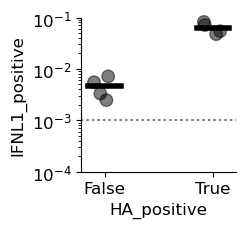

In [3]:
graph = flow[(flow.virus == 'NS1-stop')]
graph = graph.groupby(['HA_positive', 'replicate']).mean().reset_index()

fig,ax = plt.subplots(figsize=(2,2))
sns.stripplot(x='HA_positive', y='IFNL1_positive', data=graph,  edgecolor='black', order = [False, True],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0'], ax=ax, clip_on=False, alpha=0.5)
sns.despine()
pvals = []

#all vs all pvalues
for position, positive in enumerate([False, True]):
    curr = graph[graph.HA_positive == positive]
    y = curr.IFNL1_positive.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=8)
plt.ylim(0.0001,0.1)
ax.axhline(y = 0.001, c=".5", ls=":")
plt.yscale('log')
uninfected = flow[(flow.virus == 'uninfected')].IFNL1_positive.mean()
ax.axhline(y = uninfected, c=".5", ls=":")

statistic, pval = scipy.stats.ttest_ind(graph[graph.HA_positive].IFNL1_positive, graph[~(graph.HA_positive)].IFNL1_positive, equal_var=False)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
plt.savefig('Figures/infectionIFNflow.pdf')


Do IFN+ cells tend to have higher levels of flu expression than IFN-?

The null hypothesis is rejected at a pvalue of 0.003892036812898891


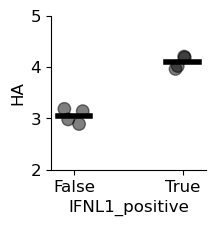

In [4]:
fig,ax = plt.subplots(figsize=(2,2))

graph = flow[(flow.virus == 'NS1-stop') & (flow.HA_positive)].groupby(['IFNL1_positive', 'replicate']).median().reset_index()


sns.stripplot(x='IFNL1_positive', y='HA', data=graph,  edgecolor='black', order = [False, True],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0'], ax=ax, clip_on=False, alpha=0.5)
sns.despine()

statistic, pval = stats.ttest_rel(graph[graph.IFNL1_positive].HA, graph[~(graph.IFNL1_positive)].HA)
for position, positive in enumerate([False, True]):
    curr = graph[graph.IFNL1_positive == positive]
    y = curr.HA.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=8)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
    

        
ax.set_ylabel('HA')
ax.set_ylim(2,5)
plt.savefig('Figures/IFNvsfluBurdenFlow.pdf', format='pdf', bbox_inches = "tight")


How does HA expression correlate with probability of interferon induction?

/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


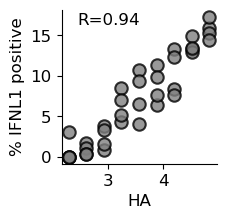

In [5]:
graph = flow[(flow.virus == 'NS1-stop') & (flow.HA_positive)]
fig,ax = plt.subplots(figsize=(2,2))

#quantiles
#divide whole range into 8ths from threshold to 99th percentile
maxVal = graph.HA.quantile(0.95)
minVal = graph.HA.min()
steps = (maxVal - minVal)/7

graph['expression_bin'] =  ((graph.HA-minVal)/steps).apply(np.ceil) 
#set top bin to the maxVal
graph.loc[graph.expression_bin > 8, 'expression_bin'] = 8
graph = graph.groupby(['replicate', 'expression_bin']).mean().reset_index()
graph['HA'] = graph.expression_bin * steps + minVal
graph['IFNL1 positive'] = graph.IFNL1_positive * 100
sns.scatterplot(data=graph, x="HA", y="IFNL1 positive", color = '0.5', edgecolor='0',        
                linewidth=1.5, s=80, ax=ax, alpha=0.8)

sns.despine()
spearman = round(graph.corr('spearman')['IFNL1_positive']['HA'],2)
a = ax.text(0.1, 0.9, 'R=' + str(spearman), transform=ax.transAxes, fontsize=12)

plt.ylabel('% IFNL1 positive')

plt.savefig('Figures/probIFNpositivityFlowNS1mut.pdf', format='pdf', bbox_inches = "tight")


## Stochastic segment absence

M and NS staining

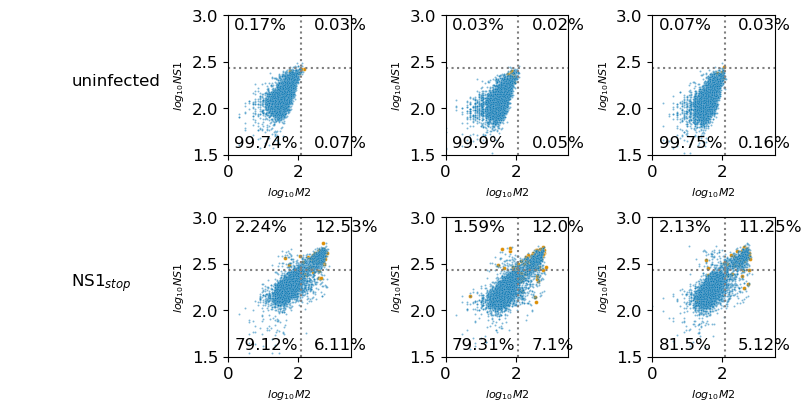

In [6]:


datafolder = "Data/FlowCytometry/NS_M/"
M2staining = []
for file in glob.glob(datafolder + '*.csv'):
    tempData = pd.read_csv(file)
    fileSeg = file.split('/')[-1].split('_')
    tempData['virus'] = fileSeg[0]
    tempData['replicate'] = fileSeg[1][:-4]
    M2staining += [tempData]
M2staining = pd.concat(M2staining)
M2staining = M2staining.rename(columns = {'M2-A':'M2', 'NEP_HA-A':'NS1', 
                                               'IFNL1-A':'IFNL1'})

#set some gates
gateThresh = 0.999
thresholds = {}
for fluor in (['M2', 'NS1', 'IFNL1']):
    #average value for that quantile
    threshold = M2staining.groupby(
        ['virus', 'replicate'])[fluor].quantile(gateThresh).groupby(['virus']).mean().uninfected
    M2staining[fluor + '_positive']  = M2staining[fluor] > threshold
    #log transform but shift negatives to the right
    minVal = M2staining[fluor].min()
    M2staining[fluor] = np.log10(M2staining[fluor]-minVal + 1)
    thresholds[fluor] = np.log10(threshold-minVal + 1)




popOrder = ['uninfected',  'NS1mut']
nameOrder = ['uninfected', 'NS1$_{stop}$']
replicates = ['1','2','3']
rows = len(popOrder)
columns =  len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = M2staining[(M2staining['virus'] == population) & (M2staining.replicate == replicate) ]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sampled = currFrame.sample(5000)
            sns.scatterplot(data = sampled[sampled.IFNL1_positive], x='M2', y='NS1', legend=False, rasterized=True, s=8,  color=colors[1])
            sns.scatterplot(data = sampled[~(sampled.IFNL1_positive)], x='M2', y='NS1', legend=False, rasterized=True, s=2, alpha=0.5, color=colors[0])
            plt.xlabel("$log_{10}{M2}$", fontsize=8)
            plt.ylabel("$log_{10}{NS1}$", fontsize=8)
            ax.axvline(x = thresholds['M2'], c=".5", ls=":")
            ax.axhline(y = thresholds['NS1'], c=".5", ls=":")
            plt.ylim(1.5,3)
            ax.set_xlim(0,3.5)
            total = len(currFrame)
            doubleNeg = len(currFrame[~(currFrame.M2_positive) & ~(currFrame.NS1_positive)])
            singPosY = len(currFrame[~(currFrame.M2_positive) & (currFrame.NS1_positive)])
            singPosX = len(currFrame[(currFrame.M2_positive) & ~(currFrame.NS1_positive)])
            doubPos = len(currFrame[(currFrame.M2_positive) & (currFrame.NS1_positive)])
            ax.text(0.05, 0.05, str(round(doubleNeg/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.05, 0.9, str(round(singPosY/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.05, str(round(singPosX/total * 100,2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.9, str(round(doubPos/total * 100,2)) + '%', transform=ax.transAxes)   
        currCol+=1

plt.savefig('Figures/NS1M2_stained_dist.pdf', format='pdf', bbox_inches = "tight")




and HA and NS1, wt and mutant

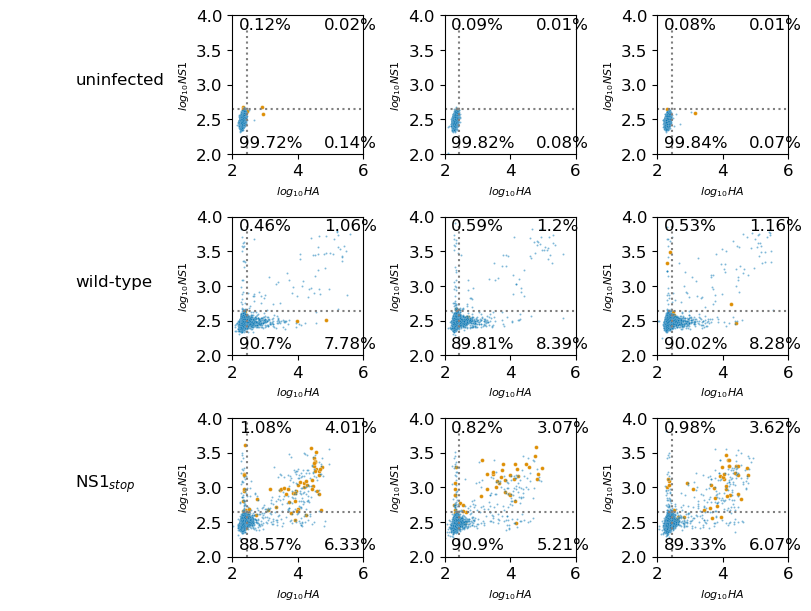

In [7]:

datafolder = "Data/FlowCytometry/NS_HA/"


HAstaining = []
for file in glob.glob(datafolder + '*.csv'):
    tempData = pd.read_csv(file)
    fileSeg = file.split('/')[-1].split('_')
    tempData['virus'] = fileSeg[0]
    tempData['replicate'] = fileSeg[1][:-4]
    HAstaining += [tempData]
HAstaining = pd.concat(HAstaining)
HAstaining = HAstaining.rename(columns = {'Comp-APC-A':'HA', 'Comp-BV421-A':'NS1', 
                                               'Comp-FITC-A':'IFNL1'})

#set some gates
gateThresh = 0.999
thresholds = {}
for fluor in (['HA', 'NS1', 'IFNL1']):
    #average value for that quantile
    threshold = HAstaining.groupby(
        ['virus', 'replicate'])[fluor].quantile(gateThresh).groupby(['virus']).mean().uninfected
    HAstaining[fluor + '_positive']  = HAstaining[fluor] > threshold
    #log transform but shift negatives to the right
    minVal = HAstaining[fluor].min()
    HAstaining[fluor] = np.log10(HAstaining[fluor]-minVal + 1)
    thresholds[fluor] = np.log10(threshold-minVal + 1)




popOrder = ['uninfected', 'WT', 'NS1mut']
nameOrder = ['uninfected','wild-type', 'NS1$_{stop}$']
replicates = ['1','2','3']
rows = len(popOrder)
columns =  len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = HAstaining[(HAstaining['virus'] == population) & (HAstaining.replicate == replicate) ]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sampled = currFrame.sample(5000)
            sns.scatterplot(data = sampled[sampled.IFNL1_positive], x='HA', y='NS1', legend=False, rasterized=True, s=8,  color=colors[1])
            sns.scatterplot(data = sampled[~(sampled.IFNL1_positive)], x='HA', y='NS1', legend=False, rasterized=True, s=2, alpha=0.5, color=colors[0])
            plt.xlabel("$log_{10}{HA}$", fontsize=8)
            plt.ylabel("$log_{10}{NS1}$", fontsize=8)
            ax.axvline(x = thresholds['HA'], c=".5", ls=":")
            ax.axhline(y = thresholds['NS1'], c=".5", ls=":")
            plt.ylim(2,4)
            ax.set_xlim(2,6)
            total = len(currFrame)
            doubleNeg = len(currFrame[~(currFrame.HA_positive) & ~(currFrame.NS1_positive)])
            singPosY = len(currFrame[~(currFrame.HA_positive) & (currFrame.NS1_positive)])
            singPosX = len(currFrame[(currFrame.HA_positive) & ~(currFrame.NS1_positive)])
            doubPos = len(currFrame[(currFrame.HA_positive) & (currFrame.NS1_positive)])
            ax.text(0.05, 0.05, str(round(doubleNeg/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.05, 0.9, str(round(singPosY/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.05, str(round(singPosX/total * 100,2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.9, str(round(doubPos/total * 100,2)) + '%', transform=ax.transAxes)   
        currCol+=1
plt.savefig('Figures/NS1HA_stained_dist.pdf', format='pdf', bbox_inches = "tight")


Using HA/NS1, and M2/NS1 datasets, lets generate all conditional data necessary.

As with our single-cell data, we may see a bias of segment-presence with higher levels of staining, in fact, it may even be worse due to detection thresholds doubtless also scaling with relative levels of staining.

So, as with single-cell data, lets use the mean value observed in IFN+, NS1- cells as our "threshold". This also nicely allows us to subset biologically-similar staining levels despite almost certain differences in relative staining efficiencies between antibodies.

Plot relative enrichment of each individual replicate.



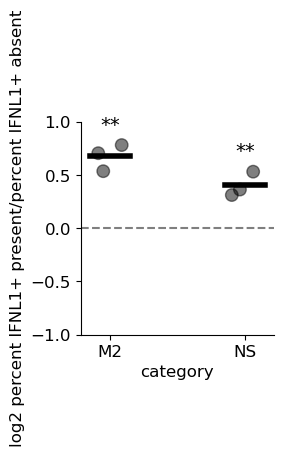

In [13]:

        
graph = []
fig,ax = plt.subplots(1,1, figsize=(3,3))

#M2+ NS1 +/- 
currFrame = M2staining[(M2staining.virus == 'NS1mut') & (M2staining.M2_positive)]
#threshold M2 high
currFrame = currFrame[currFrame.M2 > currFrame[currFrame.IFNL1_positive].M2.median()]
currFrame = currFrame.groupby(['replicate', 'NS1_positive']).mean().reset_index()[['replicate', 'NS1_positive', 'IFNL1_positive']]
currFrame = currFrame.pivot(index='replicate', columns='NS1_positive', values=['IFNL1_positive']).reset_index()
currFrame['enrichment'] = currFrame['IFNL1_positive'][True]/currFrame['IFNL1_positive'][False]
currFrame['category'] = 'NS'
graph += [currFrame]

#NS1+ M2 +/- 
currFrame = M2staining[(M2staining.virus == 'NS1mut') & (M2staining.NS1_positive)]
#threshold NS1 high
currFrame = currFrame[currFrame.NS1 > currFrame[currFrame.IFNL1_positive].NS1.median()]
currFrame = currFrame.groupby(['replicate', 'M2_positive']).mean().reset_index()[['replicate', 'M2_positive', 'IFNL1_positive']]
currFrame = currFrame.pivot(index='replicate', columns='M2_positive', values=['IFNL1_positive']).reset_index()
currFrame['enrichment'] = currFrame['IFNL1_positive'][True]/currFrame['IFNL1_positive'][False]
currFrame['category'] = 'M2'
graph += [currFrame]

graph = pd.concat(graph)

graph['enrichment'] = np.log2(graph.enrichment)
sns.stripplot(x='category', y='enrichment', data=graph,  edgecolor='black', order = ['M2','NS'],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0'], ax=ax, clip_on=False, alpha=0.5)
ax.set_ylabel('log2 percent IFNL1+ present/percent IFNL1+ absent')
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
ax.set_ylim(-1,1)
pvals = []
plt.sca(ax)


#1 sample t-test for if divergent from no enrichment
for position, category in enumerate(['M2','NS']):
    curr = graph[graph['category'] == category]
    tstat, pval = stats.ttest_1samp(curr.enrichment, popmean =0, alternative= 'greater')
    pvals += [pval]
    y = curr.enrichment.mean()
    plt.plot([position-0.15, position+0.15], [y, y], lw=4, c='k', zorder=8)
    
    

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
for position, val in enumerate(pvals):
    if val:
        y = graph[graph['category'] == ['M2', 'NS'][position]].enrichment.max() + 0.1
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)

plt.tight_layout()

plt.savefig('Figures/SegmentAbsenceFlow.pdf', format='pdf', bbox_inches = "tight")


Seperated

array([ True,  True])

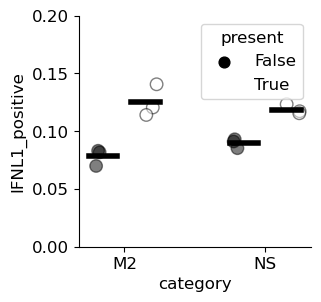

In [14]:
graph = []
fig,ax = plt.subplots(1,1, figsize=(3,3))

#M2+ NS1 +/- 
currFrame = M2staining[(M2staining.virus == 'NS1mut') & (M2staining.M2_positive)]
#threshold M2 high
currFrame = currFrame[currFrame.M2 > currFrame[currFrame.IFNL1_positive].M2.median()]
currFrame = currFrame.groupby(['replicate', 'NS1_positive']).mean().reset_index()[['replicate', 'NS1_positive', 'IFNL1_positive']]
currFrame['category'] = 'NS'
currFrame = currFrame.rename(columns = {'NS1_positive':'present'})
graph += [currFrame]

#NS1+ M2 +/- 
currFrame = M2staining[(M2staining.virus == 'NS1mut') & (M2staining.NS1_positive)]
#threshold NS1 high
currFrame = currFrame[currFrame.NS1 > currFrame[currFrame.IFNL1_positive].NS1.median()]
currFrame = currFrame.groupby(['replicate', 'M2_positive']).mean().reset_index()[['replicate', 'M2_positive', 'IFNL1_positive']]
currFrame['category'] = 'M2'
currFrame = currFrame.rename(columns = {'M2_positive':'present'})
graph += [currFrame]

graph = pd.concat(graph)

sns.stripplot(x='category', y='IFNL1_positive', data=graph, hue='present', edgecolor='black', order = ['M2','NS'],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0','1'], ax=ax, clip_on=False, alpha=0.5)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.ylim(0,0.2)
pvals = []

plt.sca(ax)
for position, category in enumerate(['M2','NS']):
    currFrame = graph[graph.category == category]
    y = currFrame[~(currFrame.present)]['IFNL1_positive'].mean()
    set1 = currFrame[~(currFrame.present)]['IFNL1_positive']
    plt.plot([position-0.25, position-0.05], [y, y], lw=4, c='k', zorder=8)
    y = currFrame[(currFrame.present)]['IFNL1_positive'].mean()
    set2=currFrame[(currFrame.present)]['IFNL1_positive']
    pvals += [stats.ttest_ind(set1, set2)[1]]
    plt.plot([position+0.05, position+0.25], [y, y], lw=4, c='k', zorder=8)

plt.savefig('Figures/SegmentAbsenceFlow.pdf', format='pdf', bbox_inches = "tight")
multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

pval for NS and HA staining is 0.03793583902952829


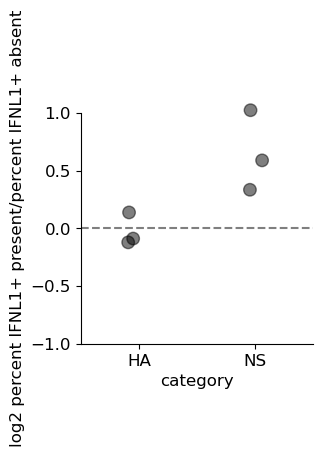

In [37]:
graph = []
fig,ax = plt.subplots(1,1, figsize=(3,3))

#NS1+ HA +/-
currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.NS1_positive)]
#threshold NS1 high
currFrame = currFrame[currFrame.NS1 > currFrame[currFrame.IFNL1_positive].NS1.median()]
currFrame = currFrame.groupby(['replicate', 'HA_positive']).mean().reset_index()[['replicate', 'HA_positive', 'IFNL1_positive']]
currFrame = currFrame.pivot(index='replicate', columns='HA_positive', values=['IFNL1_positive']).reset_index()
currFrame['enrichment'] = currFrame['IFNL1_positive'][True]/currFrame['IFNL1_positive'][False]
currFrame['category'] = 'HA'
graph += [currFrame]

#HA+ NS1 +/-
currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.HA_positive)]
#threshold HA high
currFrame = currFrame[currFrame.HA > currFrame[currFrame.IFNL1_positive].HA.median()]

currFrame = currFrame.groupby(['replicate', 'NS1_positive']).mean().reset_index()[['replicate', 'NS1_positive', 'IFNL1_positive']]
currFrame = currFrame.pivot(index='replicate', columns='NS1_positive', values=['IFNL1_positive']).reset_index()
currFrame['enrichment'] = currFrame['IFNL1_positive'][True]/currFrame['IFNL1_positive'][False]
currFrame['category'] = 'NS'
graph += [currFrame]
graph = pd.concat(graph)

graph['enrichment'] = np.log2(graph.enrichment)
sns.stripplot(x='category', y='enrichment', data=graph,  edgecolor='black', order = ['HA','NS'],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0'], ax=ax, clip_on=False, alpha=0.5)
ax.set_ylabel('log2 percent IFNL1+ present/percent IFNL1+ absent')
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
ax.set_ylim(-1,1)
pvals = []
plt.sca(ax)

#1 sample t-test for if divergent from no enrichment
ttest, pval = stats.ttest_rel(graph[graph.category == 'HA'].enrichment, graph[graph.category == 'NS'].enrichment)

print("pval for NS and HA staining is {0}".format(pval))
plt.savefig('Figures/HANS.pdf', format='pdf', bbox_inches = "tight")


array([False,  True])

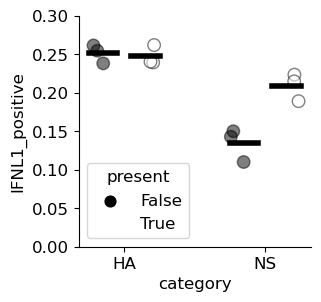

In [15]:
graph = []
fig,ax = plt.subplots(1,1, figsize=(3,3))

#NS1+ HA +/-
currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.NS1_positive)]
#threshold NS1 high
currFrame = currFrame[currFrame.NS1 > currFrame[currFrame.IFNL1_positive].NS1.median()]
currFrame = currFrame.groupby(['replicate', 'HA_positive']).mean().reset_index()[['replicate', 'HA_positive', 'IFNL1_positive']]
currFrame['category'] = 'HA'
currFrame = currFrame.rename(columns = {'HA_positive':'present'})

graph += [currFrame]

#HA+ NS1 +/-
currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.HA_positive)]
#threshold HA high
currFrame = currFrame[currFrame.HA > currFrame[currFrame.IFNL1_positive].HA.median()]

currFrame = currFrame.groupby(['replicate', 'NS1_positive']).mean().reset_index()[['replicate', 'NS1_positive', 'IFNL1_positive']]
currFrame['category'] = 'NS'
currFrame = currFrame.rename(columns = {'NS1_positive':'present'})
graph += [currFrame]
graph = pd.concat(graph)

sns.stripplot(x='category', y='IFNL1_positive', data=graph,  edgecolor='black', hue='present', order = ['HA','NS'],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0','1'], ax=ax, clip_on=False, alpha=0.5)
plt.ylim(0,0.3)
sns.despine()
pvals = []
for position, category in enumerate(['HA','NS']):
    currFrame = graph[graph.category == category]
    y = currFrame[~(currFrame.present)]['IFNL1_positive'].mean()
    set1 = currFrame[~(currFrame.present)]['IFNL1_positive']
    plt.plot([position-0.25, position-0.05], [y, y], lw=4, c='k', zorder=8)
    y = currFrame[(currFrame.present)]['IFNL1_positive'].mean()
    set2 = currFrame[(currFrame.present)]['IFNL1_positive']
    pvals += [stats.ttest_ind(set1,set2)[1]]
    plt.plot([position+0.05, position+0.25], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/HANS.pdf', format='pdf', bbox_inches = "tight")
multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

Is this due to staining efficiency?

pval for NS and HA staining is 0.9152311137866669


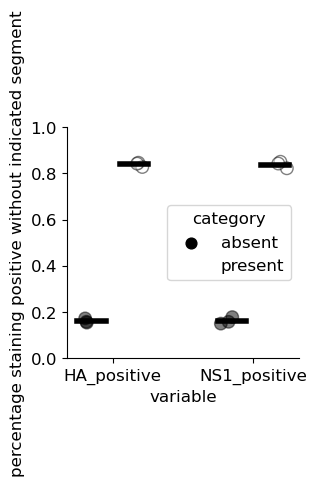

In [53]:
graph = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.NS1_positive)]
#threshold NS1 high
graph = graph[graph.NS1 > graph[graph.IFNL1_positive].NS1.median()]
graph = graph.groupby(['replicate']).mean().reset_index()[['replicate', 'HA_positive']]


currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.HA_positive)]
#threshold NS1 high
currFrame = currFrame[currFrame.HA > currFrame[currFrame.IFNL1_positive].HA.median()]
currFrame = currFrame.groupby(['replicate']).mean().reset_index()[['replicate', 'NS1_positive',]]

graph = graph.merge(currFrame, on='replicate')

graph = graph.melt(id_vars = ['replicate'], value_vars= ['HA_positive','NS1_positive'])
graph['value'] = 1-graph['value']
tstat, pval  = stats.ttest_rel(graph[graph.variable =='HA_positive'].value, graph[graph.variable =='NS1_positive'].value)
print("pval for NS and HA staining is {0}".format(pval))
graph['category'] = 'absent'
extra = graph.copy()
extra['value'] = 1- extra['value']
extra['category'] = 'present'
graph = pd.concat([graph,extra])

fig,ax = plt.subplots(1,1, figsize=(3,3))
sns.stripplot(x='variable', y='value', data=graph, hue='category',  edgecolor='black', order = ['HA_positive','NS1_positive'],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0', '1'], ax=ax, clip_on=False, alpha=0.5)
ax.set_ylabel('percentage staining positive without indicated segment')
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.set_ylim(0,1)
pvals = []
plt.sca(ax)



for position, category in enumerate(['HA_positive','NS1_positive']):
    currFrame = graph[graph['variable'] == category]
    y = currFrame[(currFrame.category == 'absent')]['value'].mean()
    plt.plot([position-0.25, position-0.05], [y, y], lw=4, c='k', zorder=8)
    y = currFrame[(currFrame.category == 'present')]['value'].mean()
    plt.plot([position+0.05, position+0.25], [y, y], lw=4, c='k', zorder=8)
    


plt.savefig('Figures/SegmentAbsenceFlowEfficiency.pdf', format='pdf', bbox_inches = "tight")




In [39]:
currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.HA_positive) & (HAstaining.NS1_positive) ]



stuff = []
for replicate in set(currFrame.replicate):
    tempFrame = currFrame[currFrame.replicate == replicate]
    tempFrame['quantHA'] = tempFrame.apply(lambda row: stats.percentileofscore(tempFrame.HA,row.HA), axis=1)
    tempFrame['quantNS'] = tempFrame.apply(lambda row: stats.percentileofscore(tempFrame.NS1,row.NS1), axis=1)
    stuff += [tempFrame]

stuff = pd.concat(stuff)
stuff['ratio'] = np.log10(stuff.quantNS/stuff.quantHA)
stuff = stuff.groupby(['replicate', 'IFNL1_positive']).median().reset_index()

/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


pval for NS and HA staining is 0.046752480246032055


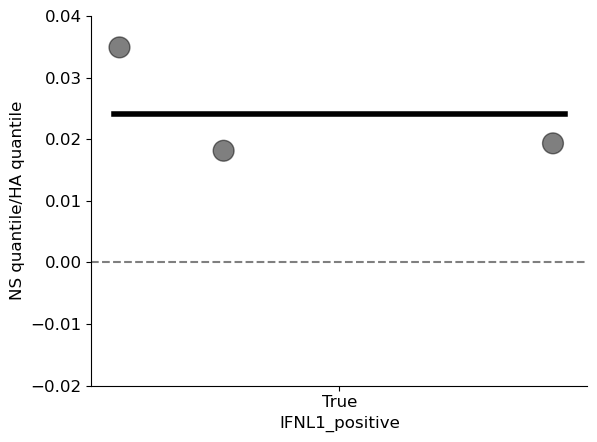

In [50]:


ax = sns.stripplot(x='IFNL1_positive', y='ratio', data=stuff,  edgecolor='black', order = [ True],
            jitter=True, dodge=True, linewidth=1, s=15, palette=['0'], clip_on=False, alpha=0.5)
sns.despine()
ax.set_ylim(-0.02,0.04)


ax.axhline(y=0, color = 'k',ls = '--', alpha =0.5)

tstat, pval  = stats.ttest_1samp(stuff[stuff.IFNL1_positive].ratio, popmean=0)

y= stuff[stuff.IFNL1_positive].ratio.mean()
plt.plot([-0.1, 0.1], [y, y], lw=4, c='k', zorder=8)
    
    


        
ax.set_ylabel('NS quantile/HA quantile')

plt.savefig('Figures/HANSquantitativeRatio.pdf', format='pdf', bbox_inches = "tight")
print("pval for NS and HA staining is {0}".format(pval))


Now NS absence and compare WT and NS1mut

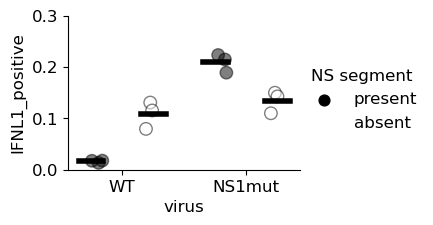

In [42]:
graph = []
#NS1+ HA +/- NS1mut
currFrame = HAstaining[(HAstaining.virus == 'NS1mut') & (HAstaining.HA_positive)]
#threshold HA high
threshold = currFrame[currFrame.IFNL1_positive].HA.median()
currFrame = currFrame[currFrame.HA > threshold]
currFrame = currFrame.groupby(['replicate', 'NS1_positive']).mean().reset_index()[['replicate', 'NS1_positive', 'IFNL1_positive']]
currFrame['virus'] = 'NS1mut'
graph += [currFrame]


#NS1+ HA +/- WT
currFrame = HAstaining[(HAstaining.virus == 'WT') & (HAstaining.HA_positive)]
#threshold HA high, but same as above
currFrame = currFrame[currFrame.HA > threshold]
currFrame = currFrame.groupby(['replicate', 'NS1_positive']).mean().reset_index()[['replicate', 'NS1_positive', 'IFNL1_positive']]
currFrame['virus'] = 'WT'
graph += [currFrame]

graph=pd.concat(graph)

fig,ax = plt.subplots(figsize=(3,2))
sns.stripplot(x='virus', y='IFNL1_positive', data=graph,  edgecolor='black', order = ['WT', 'NS1mut'],hue='NS1_positive', hue_order=[True, False],
            jitter=True, dodge=True, linewidth=1, s=9, palette=['0', '1'], ax=ax, clip_on=False, alpha=0.5)
sns.despine()
pvals = []
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(handles[0:2], ['present', 'absent'],title='NS segment', bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.,frameon=False)
ax.set_ylim(0,0.25)
#all vs all pvalues
firstOrder = ['WT', 'NS1mut']
secondOrder = [True, False]
for position, virus in enumerate(firstOrder):
    curr = graph[graph.virus == virus]
    y = curr[curr.NS1_positive].IFNL1_positive.mean()
    plt.plot([position-0.35, position-0.15], [y, y], lw=4, c='k', zorder=8)
    y = curr[~(curr.NS1_positive)].IFNL1_positive.mean()
    plt.plot([position+0.15, position+0.35], [y, y], lw=4, c='k', zorder=8)
plt.ylim(0,0.3)
plt.savefig('Figures/WTNS1mut_presAbs.pdf')

ANOVA, tukey, just print results and draw in later.

In [42]:
graph['category'] = graph.virus + '_' + graph.NS1_positive.astype('str') 


stat, pval = scipy.stats.f_oneway(*[graph[graph.category == category].IFNL1_positive for category in set(graph.category)])
if pval < 0.05:
    tukey = pairwise_tukeyhsd(endog=graph['IFNL1_positive'],
                              groups=graph['category'],
                              alpha=0.05)
    print(tukey)
else:
    print('No significant difference detected by ANOVA at a pvalue of 0.05')

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
NS1mut_False NS1mut_True   0.0748 0.0061  0.0246   0.125   True
NS1mut_False    WT_False  -0.0257 0.4123 -0.0759  0.0245  False
NS1mut_False     WT_True  -0.1182  0.001 -0.1684  -0.068   True
 NS1mut_True    WT_False  -0.1005  0.001 -0.1507 -0.0503   True
 NS1mut_True     WT_True   -0.193  0.001 -0.2432 -0.1428   True
    WT_False     WT_True  -0.0925 0.0016 -0.1427 -0.0423   True
---------------------------------------------------------------


## Reporter sorting

Rationale behind using complementing cells to understand interferon in a high-defective population. Particle-normalized MOI of 0.2

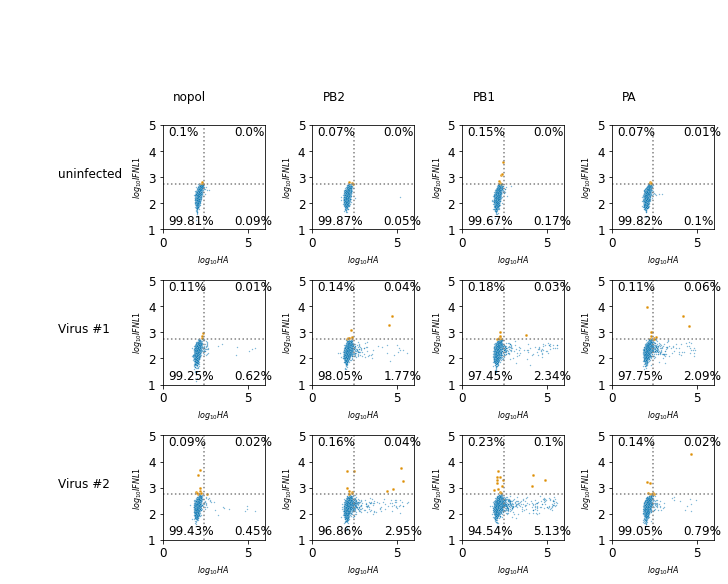

In [14]:
data = []
for file in glob.glob('Data/FlowCytometry/HiDI_complemented/*.csv'):
    currFrame = pd.read_csv(file)
    characteristics = file.split('/')[-1].split('_')
    virus = characteristics[0]
    complementation = characteristics[1][:-4]
    currFrame['virus'] = virus
    currFrame['complementation'] = complementation
    data += [currFrame]
data = pd.concat(data)
data = data.rename(columns = {'APC-A':'HA', 'FITC-A':'IFNL1'})
#set some gates
gateThresh = 0.999
thresholds = {}
for fluor in (['HA', 'IFNL1']):
    #average value for that quantile
    threshold = data[data.virus == 'uninfected'][fluor].quantile(gateThresh)
    data[fluor + '_positive']  = data[fluor] > threshold
    #log transform but shift negatives to the right
    minVal = data[fluor].min()
    data[fluor] = np.log10(data[fluor]-minVal + 1)
    thresholds[fluor] = np.log10(threshold-minVal + 1)



popOrder = ['uninfected',  'population1', 'population2']
nameOrder = ['uninfected', 'Virus #1', 'Virus #2']
treatmentOrder = ['nopol', 'PB2', 'PB1', 'PA']
rows = len(popOrder) + 1
columns = len(treatmentOrder) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
#first row just write out treatments
currCol = 1
for treatment in treatmentOrder:
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    ax.text(0.1, 0.1, treatment, transform=ax.transAxes, fontsize=12)
    currCol +=1
currRow = 0
currCol = 0
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for treatment in treatmentOrder:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = data[(data['virus'] == population)& (data.complementation == treatment)]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sampled = currFrame.sample(5000)
            sns.scatterplot(data = sampled[sampled.IFNL1_positive], x='HA', y='IFNL1', legend=False, rasterized=True, s=8,  color=colors[1])
            sns.scatterplot(data = sampled[~(sampled.IFNL1_positive)], x='HA', y='IFNL1', legend=False, rasterized=True, s=2, alpha=0.5, color=colors[0])

            plt.xlabel("$log_{10}{HA}$", fontsize=8)
            plt.ylabel("$log_{10}{IFNL1}$", fontsize=8)
            ax.axvline(x = thresholds['HA'], c=".5", ls=":")
            ax.axhline(y = thresholds['IFNL1'], c=".5", ls=":")
            plt.ylim(1,5)
            plt.xlim(0,6)
            currCol+=1
            total = len(currFrame)
            doubleNeg = len(currFrame[~(currFrame.HA_positive) & ~(currFrame.IFNL1_positive)])
            singPosY = len(currFrame[~(currFrame.HA_positive) & (currFrame.IFNL1_positive)])
            singPosX = len(currFrame[(currFrame.HA_positive) & ~(currFrame.IFNL1_positive)])
            doubPos = len(currFrame[(currFrame.HA_positive) & (currFrame.IFNL1_positive)])
            ax.text(0.05, 0.05, str(round(doubleNeg/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.05, 0.9, str(round(singPosY/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.05, str(round(singPosX/total * 100,2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.9, str(round(doubPos/total * 100,2)) + '%', transform=ax.transAxes)
plt.savefig('Figures/complementedFlowRaw.pdf', format='pdf', bbox_inches = "tight")



# Defectives and NS1

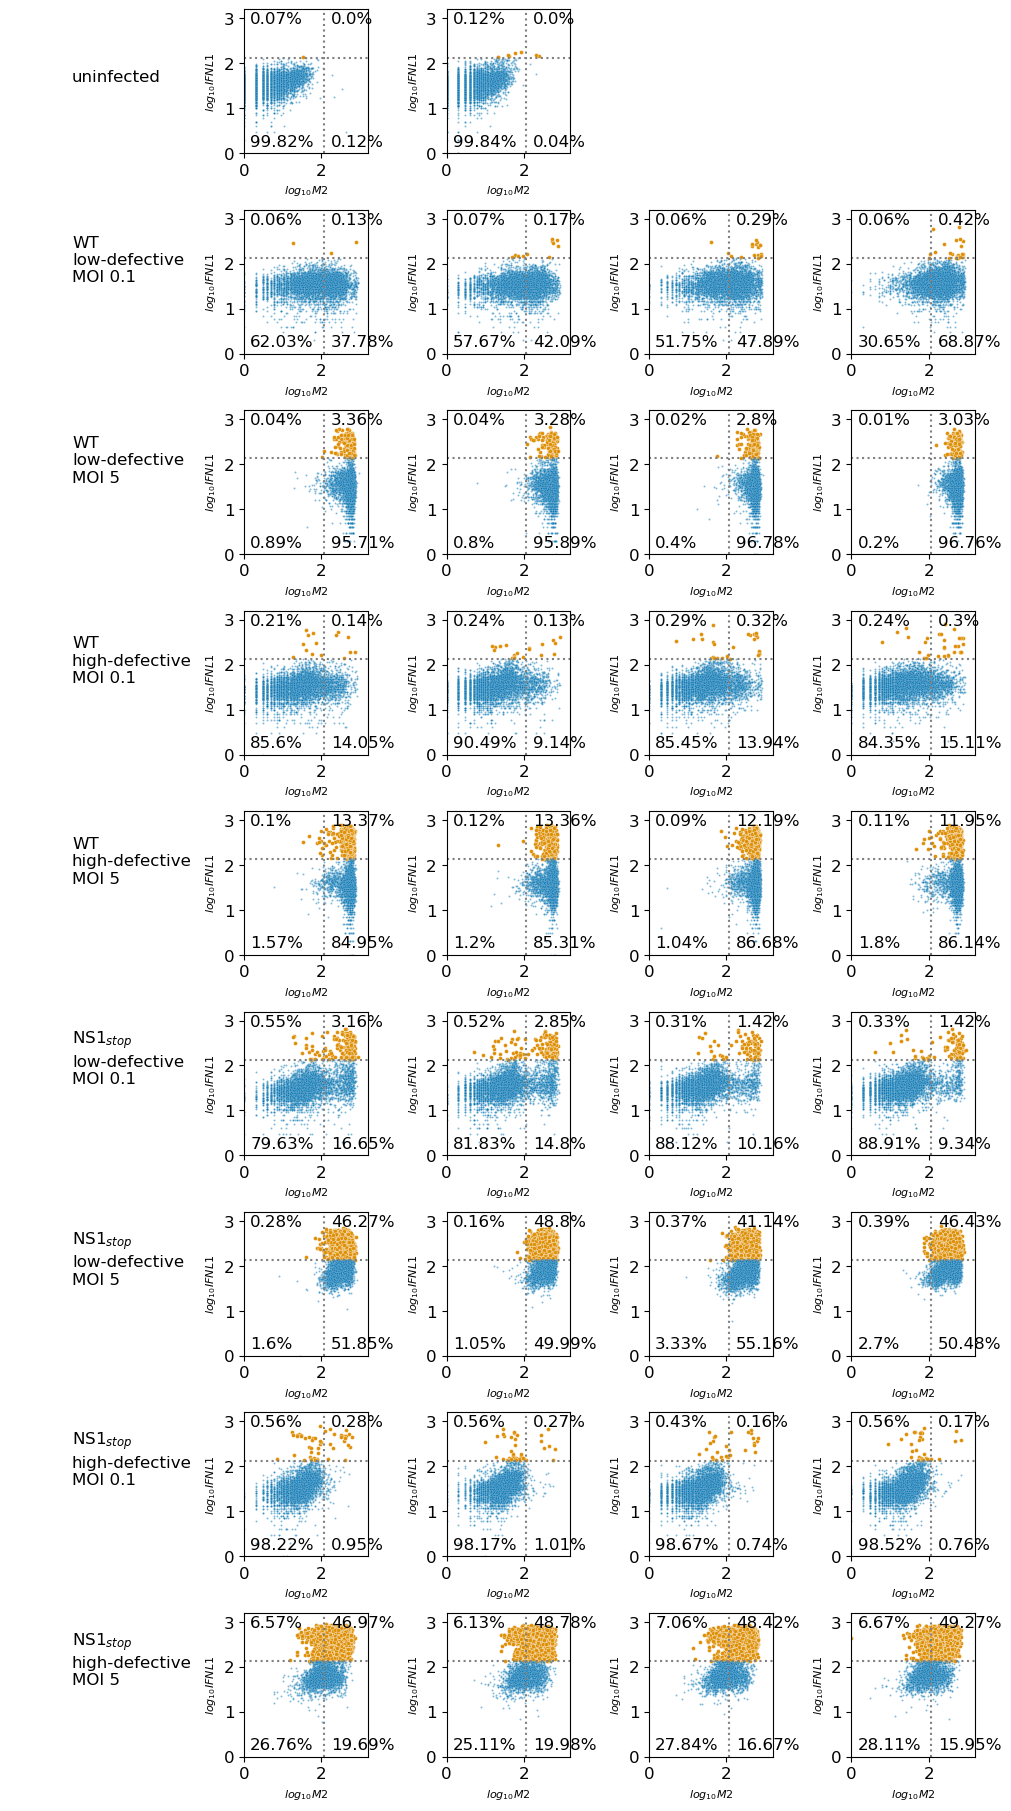

In [18]:
data = []
datafolder = "Data/FlowCytometry/NS1defectives/"
for file in glob.glob(datafolder + '*.csv'):
    currFrame = pd.read_csv(file)

    
    if os.path.basename(file).split('_')[0] != 'uninfected':
        virus, biorep, MOI, techrep = os.path.basename(file).split('_')
        lowdi = virus.find('low')
        if lowdi != -1:
            currFrame['virus'] = virus[:lowdi]
            currFrame['defectives'] = virus[lowdi:]
        else:
            hidi = virus.find('high')
            currFrame['virus'] = virus[:hidi]
            currFrame['defectives'] = virus[hidi:]
        currFrame['biorep'] = biorep
        currFrame['MOI'] = MOI
        currFrame['techrep'] = techrep.split('.')[0]
    else:
        virus, techrep = os.path.basename(file).split('.')[0].split('_')
        currFrame['virus'] = virus
        currFrame['defectives'] = virus
        currFrame['biorep'] = virus
        currFrame['MOI'] = virus
        currFrame['techrep'] = techrep.split('.')[0]
    data += [currFrame]  
data = pd.concat(data)
data = data.rename(columns={'FS00-A :: FSC 488_10-A':'FSC', 'SS02-A :: SSC 488_10-A':'SSC', 'FL03-A :: IFNL1-A':'IFNL1', 'FL29-A :: APC (Allophycocyanin)-A':'M2'})
data = data[['virus', 'defectives', 'biorep', 'MOI', 'techrep', 'M2', 'IFNL1']]
Fluors = ['M2', 'IFNL1']
thresholds = {}
gateThresh = 0.999

for fluor in Fluors:
    #average value for that quantile
    #threshold = data.groupby(
    #    ['virus', 'techrep'])[fluor].quantile(gateThresh).groupby(['virus']).mean().uninfected
    #data[fluor + '_positive']  = data[fluor] > threshold
    
    threshold = data.groupby(
        ['virus', 'techrep'])[fluor].quantile(gateThresh).uninfected[['1','2']].mean()
    data[fluor + '_positive'] = data[fluor] > threshold
    
    #log transform but shift negatives to the right
    minVal = data[fluor].min()
    data[fluor] = np.log10(data[fluor]-minVal + 1)
    thresholds[fluor] = np.log10(threshold-minVal + 1)
colors = sns.color_palette("colorblind",2)
data['population'] = data.virus + data.defectives + data.MOI
data['replicate'] = np.where(data.biorep == 'B', (data.techrep.apply(int) + 2).apply(str), data.techrep)
popOrder = ['uninfecteduninfecteduninfected',  'WTlowDIMOI0.1', 'WTlowDIMOI5', 'WThighDIMOI0.1', 'WThighDIMOI5', 'NS1lowDIMOI0.1', 'NS1lowDIMOI5', 'NS1highDIMOI0.1', 'NS1highDIMOI5']
nameOrder = ['uninfected', 'WT\nlow-defective\nMOI 0.1', 'WT\nlow-defective\nMOI 5', 'WT\nhigh-defective\nMOI 0.1', 'WT\nhigh-defective\nMOI 5', 'NS1$_{stop}$\nlow-defective\nMOI 0.1', 'NS1$_{stop}$\nlow-defective\nMOI 5', 'NS1$_{stop}$\nhigh-defective\nMOI 0.1', 'NS1$_{stop}$\nhigh-defective\nMOI 5']
replicates = ['1','2','3','4']
rows = len(popOrder)
columns =  len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = data[(data['population'] == population) & (data.replicate == replicate) ]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sampled = currFrame.sample(5000)
            sns.scatterplot(data = sampled[sampled.IFNL1_positive], x='M2', y='IFNL1', legend=False, rasterized=True, s=8,  color=colors[1])
            sns.scatterplot(data = sampled[~(sampled.IFNL1_positive)], x='M2', y='IFNL1', legend=False, rasterized=True, s=2, alpha=0.5, color=colors[0])
            plt.xlabel("$log_{10}{M2}$", fontsize=8)
            plt.ylabel("$log_{10}{IFNL1}$", fontsize=8)
            ax.axvline(x = thresholds['M2'], c=".5", ls=":")
            ax.axhline(y = thresholds['IFNL1'], c=".5", ls=":")
            ax.set_ylim(0,3.2)
            ax.set_xlim(0,3.2)
            total = len(currFrame)
            doubleNeg = len(currFrame[~(currFrame.M2_positive) & ~(currFrame.IFNL1_positive)])
            singPosY = len(currFrame[~(currFrame.M2_positive) & (currFrame.IFNL1_positive)])
            singPosX = len(currFrame[(currFrame.M2_positive) & ~(currFrame.IFNL1_positive)])
            doubPos = len(currFrame[(currFrame.M2_positive) & (currFrame.IFNL1_positive)])
            ax.text(0.05, 0.05, str(round(doubleNeg/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.05, 0.9, str(round(singPosY/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.05, str(round(singPosX/total * 100,2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.9, str(round(doubPos/total * 100,2)) + '%', transform=ax.transAxes)   
        currCol+=1

plt.savefig('Figures/IFNL1M2_stained_dist.pdf', format='pdf', bbox_inches = "tight")

,MOI,defectives,biorep,techrep,M2,IFNL1,M2_positive,IFNL1_positive,IFNL1_positive_log
0,MOI0.1,highDI,A,1,1.425793,1.536473,0.012225,0.838447,-0.254209
1,MOI0.1,highDI,A,2,1.424062,1.545675,0.012775,0.827727,-0.272773
2,MOI0.1,highDI,B,1,1.303481,1.518066,0.009061,0.587229,-0.768006
3,MOI0.1,highDI,B,2,1.370921,1.539177,0.009249,0.724325,-0.465290
4,MOI0.1,lowDI,A,1,1.647909,1.545471,0.198126,3.717046,1.894156
5,MOI0.1,lowDI,A,2,1.567184,1.561630,0.176485,3.375837,1.755245
6,MOI0.1,lowDI,B,1,1.443636,1.541117,0.115733,1.725261,0.786814
7,MOI0.1,lowDI,B,2,1.398976,1.550534,0.107593,1.749842,0.807225
8,MOI5,highDI,A,1,2.229186,2.249776,0.666642,53.547672,5.742752
9,MOI5,highDI,A,2,2.249755,2.267252,0.687602,54.910602,5.779013


MOI 0.1: p-value is 0.0015812051917113523
MOI 5: p-value is 0.002562038383415839


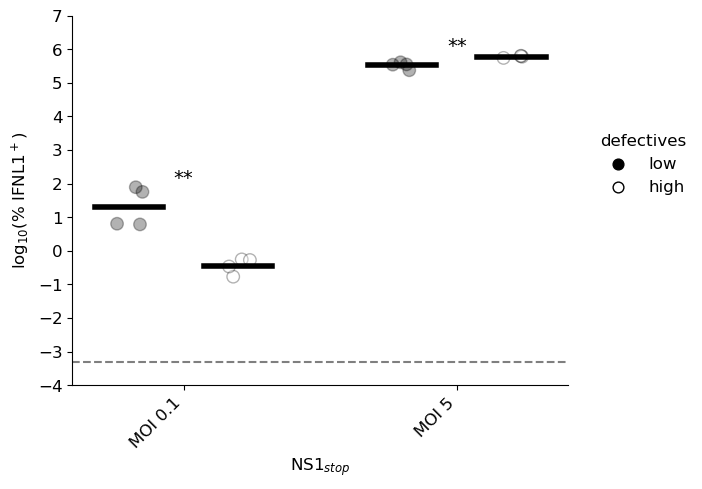

In [27]:
graphNS1 = data[(data.virus == 'NS1')]
graphNS1 = graphNS1.groupby(['MOI','defectives','biorep','techrep']).mean().reset_index()
order = ['MOI0.1', 'MOI5']
nameOrder = ['MOI 0.1', 'MOI 5']
hueOrder = ['lowDI','highDI']
graphNS1['IFNL1_positive'] = graphNS1.IFNL1_positive * 100
graphNS1['IFNL1_positive_log'] = np.log2(graphNS1.IFNL1_positive)
display(graphNS1)

ax=sns.stripplot(x='MOI', y='IFNL1_positive_log', data=graphNS1,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue='defectives', hue_order= hueOrder, palette=['0','1'], alpha = 0.3)

sns.despine()
plt.ylim(-4,7)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('NS1$_{stop}$')
ax.legend(handles[0:2], ['low', 'high'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0., frameon=False, title='defectives')

plt.ylabel('log$_{10}$(% IFNL1$^+$)')
plt.yticks(np.arange(-4,8,1))
plt.xticks(np.arange(0,2,1), nameOrder, rotation=45, ha='right')

plt.axhline(y=np.log2(0.1), color = 'k',ls = '--', alpha =0.5)
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

#stats for effect of defectives
pvals = []
for position, MOI in enumerate(order):
    curr = graphNS1[graphNS1['MOI'] == MOI]
    tstat, pval = stats.ttest_ind(curr[curr.defectives == 'lowDI'].IFNL1_positive_log, curr[curr.defectives == 'highDI'].IFNL1_positive_log)
    pvals += [pval]
    print(nameOrder[position] + ': p-value is ' + str(pvals[position]))
    y = curr[curr.defectives == 'lowDI'].IFNL1_positive_log.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=9)
    y = curr[curr.defectives == 'highDI'].IFNL1_positive_log.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=9)

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

offset = 0
for position, val in enumerate(pvals):
    if val:
        y = graphNS1[graphNS1['MOI'] == order[position]].IFNL1_positive_log.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/NS1mutDefectivesFlow.pdf', format='pdf', bbox_inches = "tight")

/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,M2_x,IFNL1_x,M2_positive_x,IFNL1_positive_x,IFNL1 positive,MOI,M2_y,IFNL1_y,M2_positive_y,IFNL1_positive_y,population,replicate
expression_bin,,,,,,,,,,,,
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,0.0,0.070634,0.0,0.033494,3.349355,116.500000,116.500000,116.500000,116.500000,116.500000,116.500000,116.500000
11.0,0.0,0.083667,0.0,0.022893,2.289270,487.083333,487.083333,487.083333,487.083333,487.083333,487.083333,487.083333
12.0,0.0,0.065349,0.0,0.019568,1.956753,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
13.0,0.0,0.113868,0.0,0.065180,6.517993,390.500000,390.500000,390.500000,390.500000,390.500000,390.500000,390.500000
14.0,0.0,0.183173,0.0,0.138755,13.875525,85.750000,85.750000,85.750000,85.750000,85.750000,85.750000,85.750000
15.0,0.0,0.164904,0.0,0.100832,10.083225,8861.500000,8861.500000,8861.500000,8861.500000,8861.500000,8861.500000,8861.500000
16.0,0.0,0.131712,0.0,0.058170,5.817023,1023.250000,1023.250000,1023.250000,1023.250000,1023.250000,1023.250000,1023.250000


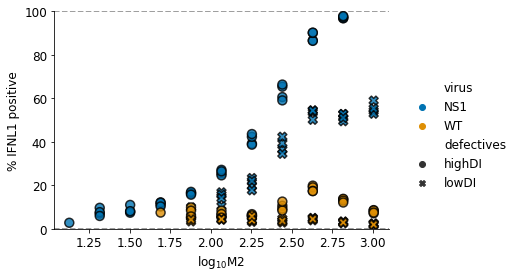

In [7]:
graph = data[(data.MOI == 'MOI5')]
fig,ax = plt.subplots(figsize=(6,4))
compiled = pd.DataFrame()

#quantiles
#divide whole range into 8ths from threshold to 95th percentile
maxVal = graph.M2.quantile(0.95)
minVal = graph.M2.min()
steps = (maxVal - minVal)/15

graph['expression_bin'] =  ((graph.M2-minVal)/steps).apply(np.ceil) 
#set top bin to the maxVal
graph.loc[graph.expression_bin > 16, 'expression_bin'] = 16

#remove bins with less than 100 observations
bincounts = graph.groupby(['virus', 'defectives', 'biorep', 'techrep', 'expression_bin']).count().reset_index()
bins = bincounts[bincounts['M2_positive'] > 100]

graph = graph.groupby(['virus', 'defectives', 'biorep', 'techrep', 'expression_bin']).mean().reset_index()
graph['M2'] = graph.expression_bin * steps + minVal
graph['IFNL1 positive'] = graph.IFNL1_positive * 100

graph = graph.merge(bins, on=['virus', 'defectives', 'biorep', 'techrep', 'expression_bin'])

sns.scatterplot(data=graph, x="M2_x", y="IFNL1 positive", palette = sns.color_palette("colorblind",2), hue = 'virus', style = 'defectives', edgecolor='0',        
                linewidth=1.5, s=80, ax=ax, alpha=0.8)
plt.ylim(0,100)

plt.axhline(y=0.1, color = 'k',ls = '--', alpha =0.5)
plt.axhline(y=100, color = 'k',ls = '--', alpha =0.5)

sns.despine()

#handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False)

plt.xlabel('log$_{10}$M2')
plt.ylabel('% IFNL1 positive')

plt.savefig('Figures/probIFNpositivityFlowDefectives_linear.pdf', format='pdf', bbox_inches = "tight")

display(graph[graph.virus == 'WT'][graph.defectives == 'highDI'].groupby(['expression_bin']).mean() - graph[graph.virus == 'WT'][graph.defectives == 'lowDI'].groupby(['expression_bin']).mean())

significance.

In [8]:
pvals = []
viruses = ['NS1', 'WT']
order = []
for expression in set(graph.M2_x):
    for virus in viruses:
        currFrame = graph[(graph.M2_x == expression) & (graph.virus == virus)]
        if len(currFrame) == 8:
            statistic, pval = stats.ttest_ind(currFrame[currFrame.defectives == 'highDI']['IFNL1 positive'], currFrame[currFrame.defectives == 'lowDI']['IFNL1 positive'], equal_var=False) 
            pvals += [pval]
            order += [str(expression) + '_' + virus]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
[i for (i, v) in zip(order, pvals) if v]
   

['2.0657294822088175_NS1',
 '2.2535230715005286_NS1',
 '2.2535230715005286_WT',
 '2.441316660792239_NS1',
 '2.441316660792239_WT',
 '2.62911025008395_NS1',
 '2.62911025008395_WT',
 '2.8169038393756605_NS1',
 '2.8169038393756605_WT',
 '3.004697428667371_WT']

,MOI,defectives,biorep,techrep,M2,IFNL1,M2_positive,IFNL1_positive,IFNL1_positive_log
0,MOI0.1,highDI,A,1,1.440007,1.506971,0.141988,0.350895,-1.510890
1,MOI0.1,highDI,A,2,1.304190,1.518815,0.092696,0.371051,-1.430312
2,MOI0.1,highDI,B,1,1.446132,1.536011,0.142598,0.609942,-0.713256
3,MOI0.1,highDI,B,2,1.399790,1.536249,0.154105,0.544334,-0.877436
4,MOI0.1,lowDI,A,1,1.813052,1.516937,0.379097,0.181011,-2.465855
5,MOI0.1,lowDI,A,2,1.882761,1.515259,0.422643,0.242963,-2.041189
6,MOI0.1,lowDI,B,1,1.962783,1.537629,0.481860,0.357785,-1.482833
7,MOI0.1,lowDI,B,2,2.195660,1.564807,0.692886,0.476401,-1.069752
8,MOI5,highDI,A,1,2.681267,1.677391,0.983228,13.470228,3.751702
9,MOI5,highDI,A,2,2.678936,1.683267,0.986736,13.486527,3.753447


MOI 0.1: p-value is 0.13455618393222346
MOI 5: p-value is 1.676113992425154e-07


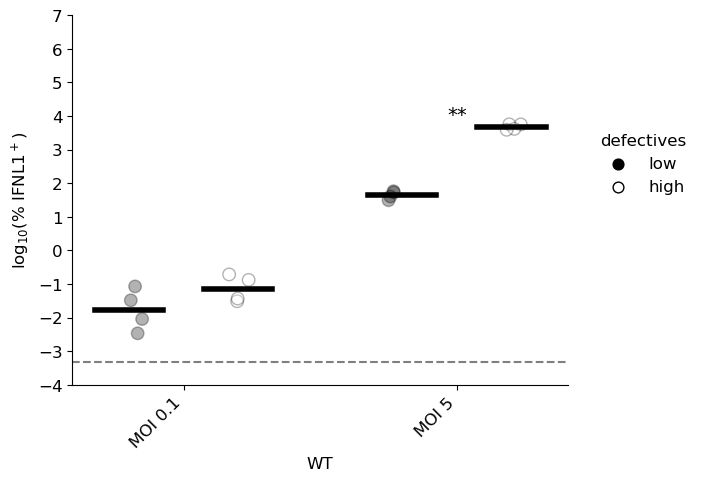

In [28]:
graphWT = data[(data.virus == 'WT')]
graphWT = graphWT.groupby(['MOI','defectives','biorep','techrep']).mean().reset_index()
order = ['MOI0.1', 'MOI5']
nameOrder = ['MOI 0.1', 'MOI 5']
hueOrder = ['lowDI','highDI']
graphWT['IFNL1_positive'] = graphWT.IFNL1_positive * 100
graphWT['IFNL1_positive_log'] = np.log2(graphWT.IFNL1_positive)
display(graphWT)

ax=sns.stripplot(x='MOI', y='IFNL1_positive_log', data=graphWT,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue='defectives', hue_order= hueOrder, palette=['0','1'], alpha = 0.3)

sns.despine()
plt.ylim(-4,7)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('WT')
ax.legend(handles[0:2], ['low', 'high'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0., frameon=False, title='defectives')

plt.ylabel('log$_{10}$(% IFNL1$^+$)')
plt.yticks(np.arange(-4,8,1))
plt.xticks(np.arange(0,2,1), nameOrder, rotation=45, ha='right')

plt.axhline(y=np.log2(0.1), color = 'k',ls = '--', alpha =0.5)
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

#stats for effect of defectives
pvals = []
for position, MOI in enumerate(order):
    curr = graphWT[graphWT['MOI'] == MOI]
    tstat, pval = stats.ttest_ind(curr[curr.defectives == 'lowDI'].IFNL1_positive_log, curr[curr.defectives == 'highDI'].IFNL1_positive_log)
    pvals += [pval]
    print(nameOrder[position] + ': p-value is ' + str(pvals[position]))
    y = curr[curr.defectives == 'lowDI'].IFNL1_positive_log.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=9)
    y = curr[curr.defectives == 'highDI'].IFNL1_positive_log.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=9)

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

offset = 0
for position, val in enumerate(pvals):
    if val:
        y = graphWT[graphWT['MOI'] == order[position]].IFNL1_positive_log.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/WTDefectivesFlow.pdf', format='pdf', bbox_inches = "tight")

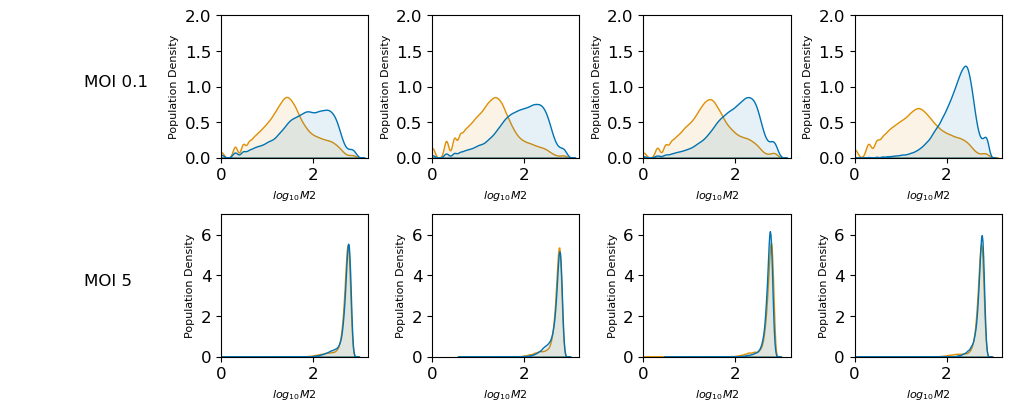

In [24]:
graph = data[data.virus == 'WT'].reset_index()
defOrder = ['lowDI', 'highDI']
graph['replicate'] = np.where(graph.biorep == 'A', graph.techrep, (graph.techrep.apply(int) + 2).apply(str))

MOIOrder = ['MOI0.1', 'MOI5']
nameOrder = ['MOI 0.1', 'MOI 5']
replicates = ['1', '2', '3', '4']
rows = len(MOIOrder)
columns = len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, MOI in enumerate(MOIOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = graph[(graph.MOI == MOI) & (graph.replicate == replicate)]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sns.kdeplot(data=currFrame, x="M2", hue = 'defectives', ax=ax, hue_order = defOrder, palette = sns.color_palette("colorblind",2), fill = True, alpha = 0.1, common_norm=False)
            plt.xlabel("$log_{10}{M2}$", fontsize=8)
            plt.ylabel("Population Density", fontsize=8)
            ax.set_xlim(0,3.2)
            
            if name == 0:
                ax.set_ylim(0,2)
            else:
                ax.set_ylim(0,7)
            

            if ~((name == 0) & (replicate == replicates[len(replicates) - 1])):
                ax.get_legend().remove()

        currCol+=1

plt.savefig('Figures/M2dist_WTdefectives.pdf', format='pdf', bbox_inches = "tight")

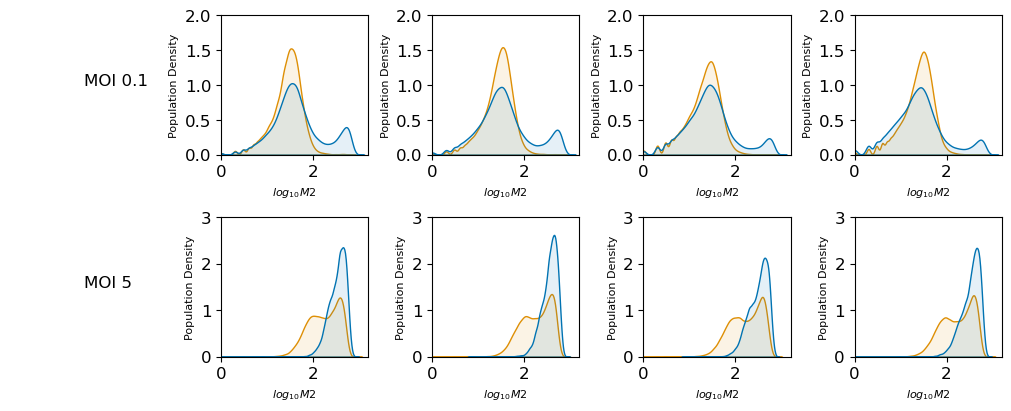

In [25]:
graph = data[data.virus == 'NS1'].reset_index()
defOrder = ['lowDI', 'highDI']
graph['replicate'] = np.where(graph.biorep == 'A', graph.techrep, (graph.techrep.apply(int) + 2).apply(str))

MOIOrder = ['MOI0.1', 'MOI5']
nameOrder = ['MOI 0.1', 'MOI 5']
replicates = ['1', '2', '3', '4']
rows = len(MOIOrder)
columns = len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, MOI in enumerate(MOIOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = graph[(graph.MOI == MOI) & (graph.replicate == replicate)]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sns.kdeplot(data=currFrame, x="M2", hue = 'defectives', ax=ax, hue_order = defOrder, palette = sns.color_palette("colorblind",2), fill = True, alpha = 0.1, common_norm=False)
            ax.set_xlim(0,3.2)
            
            if name == 0:
                ax.set_ylim(0,2)
            else:
                ax.set_ylim(0,3)
                
            plt.xlabel("$log_{10}{M2}$", fontsize=8)
            plt.ylabel("Population Density", fontsize=8)
            
            if ~((name == 0) & (replicate == replicates[len(replicates) - 1])):
                ax.get_legend().remove()
            
        currCol+=1

plt.savefig('Figures/M2dist_NS1defectives.pdf', format='pdf', bbox_inches = "tight")

2.9566485792052033
0.0
WT: p-value is 0.21502179140419153
2.6980817347512547
2.686072648484397
NS1$_{stop}$: p-value is 5.311477701875065e-07
2.5192136287670754
2.229846757046122


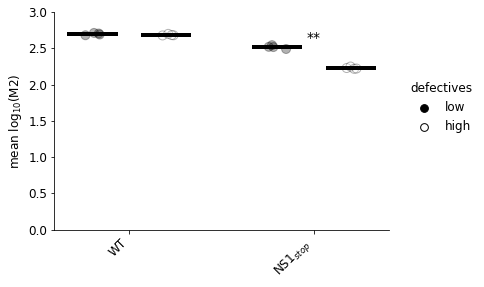

In [15]:
graph = data[(data.MOI == 'MOI5')]
graph = graph.groupby(['virus','defectives','biorep','techrep']).mean().reset_index()
order = ['WT', 'NS1']
nameOrder = ['WT', 'NS1$_{stop}$']
hueOrder = ['lowDI','highDI']

print(data.M2.max())
print(data.M2.min())

ax=sns.stripplot(x='virus', y='M2', data=graph,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue='defectives', hue_order= hueOrder, palette=['0','1'], alpha = 0.3)
#ax.set_yscale('log')

sns.despine()

#set ylim based on min (0) and max (2.956649) M2 values
plt.ylim(0,3)

handles, labels = ax.get_legend_handles_labels()
plt.xlabel('')
ax.legend(handles[0:2], ['low', 'high'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0., frameon=False, title='defectives')

plt.ylabel('mean log$_{10}$(M2)')
a = plt.xticks(np.arange(0,2,1), nameOrder, rotation=45, ha='right')

#plt.axhline(y=0.1, color = 'k',ls = '--', alpha =0.5)
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

#stats for effect of defectives
pvals = []
for position, virus in enumerate(order):
    curr = graph[graph['virus'] == virus]
    tstat, pval = stats.ttest_ind(curr[curr.defectives == 'lowDI'].M2, curr[curr.defectives == 'highDI'].M2)
    pvals += [pval]
    print(nameOrder[position] + ': p-value is ' + str(pvals[position]))
    y = curr[curr.defectives == 'lowDI'].M2.mean()
    print(y)
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=9)
    y = curr[curr.defectives == 'highDI'].M2.mean()
    print(y)
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=9)

pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

offset = 0
for position, val in enumerate(pvals):
    if val:
        y = graph[graph['virus'] == order[position]].M2.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/NS1mutDefectivesMFI.pdf', format='pdf', bbox_inches = "tight")